In [1]:
import os
import torch
import pandas as pd
from tqdm.notebook import tqdm

from ..balm.config import BalmConfig, BalmMoEConfig
from ..balm.data import load_dataset, DataCollator
from ..balm.models import (
    BalmForMaskedLM,
    BalmModel,
    BalmMoEForMaskedLM,
)

from ..balm.tokenizer import Tokenizer

from transformers import ( #for BALM
    SwitchTransformersConfig,
    RobertaTokenizer,
    DataCollatorForLanguageModeling,
    RobertaForMaskedLM,
    AutoTokenizer,
    AutoModelForMaskedLM
)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

tokenizer = Tokenizer(vocab="../balm/vocab.json")

model = BalmMoEForMaskedLM.from_pretrained("../training_runs/balmMoE_expertchoice_1shared_altern_052924/model")
model = model.to('cuda')

All model checkpoint weights were used when initializing BalmMoEForMaskedLM.

All the weights of BalmMoEForMaskedLM were initialized from the model checkpoint at /home/jovyan/shared/simone/BALM_development_51324/training_runs/balmMoE_expertchoiceBig_1shared_altern_052924/balmMoE_expertchoiceBig_1shared_altern_052924/model/model.pt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BalmMoEForMaskedLM for predictions without further training.


In [4]:
# Load therapeutic antibody sequences
df = pd.read_csv('/BALM-paper/figure4-attention/data/therapeutic-mAbs.csv')
seq_df = df[["Therapeutic", "Heavy Sequence", "Light Sequence"]].set_index("Therapeutic")

# Concat heavy and light chain sequences
seqs = []
for h, l in zip(seq_df['Heavy Sequence'], seq_df['Light Sequence']):
    seqs.append("{}<cls><cls>{}".format(h, l))
seq_names = list(seq_df.index.values)

In [5]:
tokenized_data = []
for s in tqdm(seqs):
    #print(tokenizer(s, return_tensors='pt')['input_ids'])
    tokenized_data.append(tokenizer(s, return_tensors='pt', padding=True, truncation=True, max_length=320)['input_ids'][0])
    
#i = {'input_ids': [t['input_ids'] for t in tokenized_data],
 #    'attention_mask': [t['attention_mask'] for t in tokenized_data]}

# finalize inputs
inputs = list(zip(seq_names, seqs, tokenized_data))
inputs = inputs

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
# Set the model to evaluation mode
model.eval()

# Forward pass through the model
with torch.no_grad():
    for name, seq, tokens in tqdm(inputs):
        print(f"Input: {name}")
        
        mask_1d = torch.where(tokens == 1, float(0), float(1))
# Unsqueeze to create a 2D mask
        mask_2d = mask_1d.unsqueeze(0)
# Use broadcasting to create a square attention mask
        attention_mask_2d = mask_2d.T @ mask_2d
        attention_mask_3d = attention_mask_2d.repeat(20, 1, 1)  # Now the shape will be [padded_length, padded_length, 8]
        attention_mask = attention_mask_3d.to(device)
        
       # key_padding_mask = torch.where(tokens == 1, False, True)
        #print(key_padding_mask)
        #key_padding_mask = key_padding_mask.to(device)
        
        tokens= tokens.unsqueeze(0).to(device)
       # print(tokens.shape)
        
        outputs = model(
            input_ids = tokens, attention_mask = attention_mask,
            output_attentions=True,
            output_hidden_states=True,
        )
        
        # parse the sequence
        h, l = seq.split('<cls><cls>')
        h_positions = list(range(1, len(h) + 1))
        l_positions = list(range(len(h) + 3, len(h) + 3 + len(l))) # assuming 2 seperator tokens
        all_positions = h_positions + l_positions
        
        # Get the attention values for each layer and attention head
        are_identical = torch.equal(outputs["attentions"][0], outputs["attentions"][1])
        print("tensor1 and tensor3 are identical:", are_identical)
        attentions = outputs["attentions"][0]
        num_layers = len(attentions)
        num_heads = attentions[0].size(0)

        # Extract attention values for each attention head in every layer
        all_attentions = []
        for layer in tqdm(range(num_layers)[:]): #for each layer
            layer_attentions = attentions[layer]
            for head in range(num_heads): #for each head in that layer
                head_attentions = layer_attentions[head]
                for p1 in all_positions:
                    for p2 in all_positions:
                        p1_region = "heavy" if p1 in h_positions else "light"
                        p2_region = "heavy" if p2 in h_positions else "light"
                        comp_type = f"intra-{p1_region}" if p1_region == p2_region else "cross-chain"
                        all_attentions.append(
                            {
                                "position1": p1,
                                "position2": p2,
                                "comparison": comp_type,
                                "attention": head_attentions[p1, p2].item(),
                                "layer": layer,
                                "head": head
                            }
                        )
        
        # Convert to dataframe
        attention_df = pd.DataFrame(all_attentions)
        
        # Export to csv
        attention_df.to_csv(f'./balmMoE_paired_{name}.csv', index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

Input: Bamlanivimab
tensor1 and tensor3 are identical: True


  0%|          | 0/1 [00:00<?, ?it/s]

Input: Bebtelovimab
tensor1 and tensor3 are identical: True


  0%|          | 0/1 [00:00<?, ?it/s]

Input: Cilgavimab
tensor1 and tensor3 are identical: True


  0%|          | 0/1 [00:00<?, ?it/s]

Input: Masavibart
tensor1 and tensor3 are identical: True


  0%|          | 0/1 [00:00<?, ?it/s]

Input: Regdanvimab
tensor1 and tensor3 are identical: True


  0%|          | 0/1 [00:00<?, ?it/s]

Plotting

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
def avg_attention(cc_attention_df):
    layer_dfs = []
    for layer in sorted(cc_attention_df["layer"].unique()):
        # Skip layer 3

        head_dfs = []
        for head in sorted(cc_attention_df["head"].unique()):
            cc_attention_sq = pd.pivot(
                data=cc_attention_df[(cc_attention_df["layer"] == layer) & (cc_attention_df["head"] == head)], 
                index="position1", 
                columns="position2", 
                values="attention",
                )
    
            hlen = sum(cc_attention_sq[1].isna())
            hl_sqdf = cc_attention_sq.iloc[:hlen, hlen:]
            lh_sqdf = cc_attention_sq.iloc[hlen:, :hlen].T
    
            sum_sqdf = (hl_sqdf + lh_sqdf) / 2  # average
    
            head_dfs.append(sum_sqdf)

        # average of all heads
    head_dfs = sum(head_dfs) / len(cc_attention_df["head"].unique())
    layer_dfs.append(head_dfs)

    # average of all layers except the skipped one
    avg_layer_dfs = sum(layer_dfs) / len(layer_dfs)
    return avg_layer_dfs


In [39]:
# Import full-attention file
masavibart_full = pd.read_csv('./balmMoE_paired_Masavibart.csv')

# Extract cross-chain attention values and extract average attention
masavibart_cc = masavibart_full[masavibart_full["comparison"] == "cross-chain"]
masavibart_df = avg_attention(masavibart_cc)


In [40]:
subtract_val = int(masavibart_df.columns[0]) - 1
masavibart_df.columns = [int(c) - subtract_val for c in masavibart_df.columns]
masavibart_df.columns.name = "light chain" 

In [6]:
# heavy-chain values
hc_vals = masavibart_df.sum(axis=1)
hc_vals = (hc_vals - hc_vals.min()) / (hc_vals.max() - hc_vals.min())

hc_vals = [f"{k}\t{v}" for k, v in hc_vals.items()]

In [7]:
# light-chain values
lc_vals = masavibart_df.sum(axis=0)
lc_vals = (lc_vals - lc_vals.min()) / (lc_vals.max() - lc_vals.min())

lc_vals = [f"{k}\t{v}" for k, v in lc_vals.items()]

In [19]:
hcdr_positions = {
    "CDR1": [25, 33],
    "CDR2": [50, 58],
    "CDR3": [96, 109],
}

lcdr_positions = {
    "CDR1": [26, 35],
    "CDR2": [52, 55],
    "CDR3": [91, 101],
}

h_cysteines = [21, 95]
l_cysteines = [22, 90]

'''hcdr_positions = {
    "CDR1": [25, 33],
    "CDR2": [50, 58],
    "CDR3": [96, 109],
}

lcdr_positions = {
    "CDR1": [26, 35],
    "CDR2": [52, 55],
    "CDR3": [91, 101],
}

h_cysteines = [21, 95]
l_cysteines = [21, 89]'''

'hcdr_positions = {\n    "CDR1": [25, 33],\n    "CDR2": [50, 58],\n    "CDR3": [96, 109],\n}\n\nlcdr_positions = {\n    "CDR1": [26, 35],\n    "CDR2": [52, 55],\n    "CDR3": [91, 101],\n}\n\nh_cysteines = [21, 95]\nl_cysteines = [21, 89]'

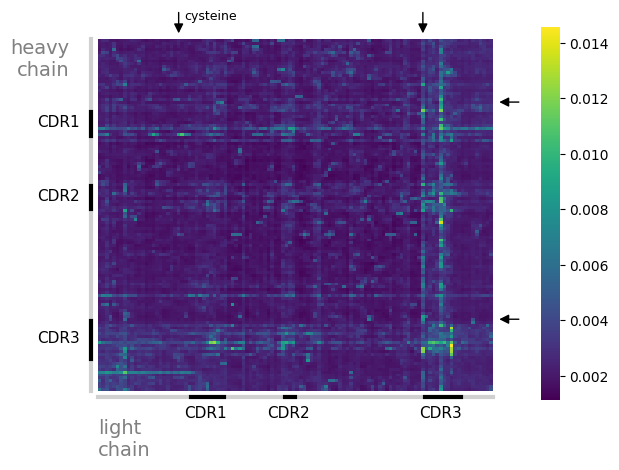

In [26]:
sns.heatmap(data=masavibart_df, cmap="viridis")

ax = plt.gca()

# set up the ticks and labels (CDR1/2/3 labels)
xlabels = sorted(lcdr_positions.keys())
ylabels = sorted(hcdr_positions.keys())

xticks = [np.mean(lcdr_positions[l]) - 0.5 for l in ylabels]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, va="center", ha="center")
ax.tick_params(axis="x", labelrotation=0, width=0, pad=6, labelsize=11)

yticks = [np.mean(hcdr_positions[l]) - 0.5 for l in xlabels]
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels, va="center", ha="right")
ax.tick_params(axis="y", labelrotation=0, width=0, pad=2, labelsize=11)

# x/y axis limits
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ymax = 0.02

# plot the CDR position lines
plt.plot([-2, -2], [ymin, ymax], color="#D0D0D0", linewidth=3)
for region in hcdr_positions:
    minval, maxval = hcdr_positions[region]
    plt.plot([-2, -2], [minval, maxval], color="k", linewidth=3)
ax.set_xlim([-3, xmax + 6])

plt.plot([xmin, xmax], [ymin + 2, ymin + 2], color="#D0D0D0", linewidth=3)
for region in lcdr_positions:
    minval, maxval = lcdr_positions[region]
    plt.plot([minval, maxval], [ymin + 2, ymin + 2], color="k", linewidth=3)
ax.set_ylim([ymin + 3, ymax - 4])


# add markers for light chain cysteines
for cys in l_cysteines:
    ax.annotate(
        "", 
        xy=[cys + 0.5, ymax - 1],
        xytext=[cys + 0.5, ymax - 10],
            arrowprops={
                "arrowstyle": "-|>", 
                "mutation_scale": 14,
                "facecolor": "k",
                "edgecolor": "k",
            },
    )
ax.text(l_cysteines[0] + 2, ymax - 10, "cysteine", ha="left", va="top", fontsize=9)


for cys in h_cysteines:
    ax.annotate(
        "", 
        xy=[xmax + 1, cys + 0.5],
        xytext=[xmax + 8, cys + 0.5],
            arrowprops={
                "arrowstyle": "-|>", 
                "mutation_scale": 14,
                "facecolor": "k",
                "edgecolor": "k",
            },
    )


# add heavy/light chain labels
ax.set_xlabel("", fontsize=0)
ax.set_ylabel("", fontsize=0)
ax.text(-8, ymax, "heavy\nchain", ha="right", va="top", rotation=0, fontsize=14, color="grey")
ax.text(ymax, ymin + 9.5, "light\nchain", ha="left", va="top", fontsize=14, color="grey")

plt.tight_layout()
plt.savefig("./crosschainattention_masavibart_balmMoE_heatmap.pdf")
plt.show()

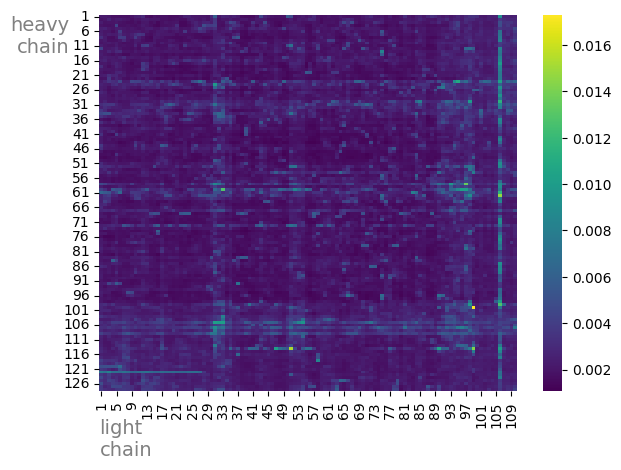

In [41]:
sns.heatmap(data=masavibart_df, cmap="viridis")

ax = plt.gca()

# x/y axis limits
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ymax = 0.02


# add heavy/light chain labels
ax.set_xlabel("", fontsize=0)
ax.set_ylabel("", fontsize=0)
ax.text(-8, ymax, "heavy\nchain", ha="right", va="top", rotation=0, fontsize=14, color="grey")
ax.text(ymax, ymin + 9.5, "light\nchain", ha="left", va="top", fontsize=14, color="grey")

plt.tight_layout()
plt.savefig("./crosschainattention_regdanvimab_balmMoE_heatmap.pdf")
plt.show()